In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import sys
sys.path.insert(0,'..')


from dfibert.tracker.nn.rl import Agent
import dfibert.envs.RLTractEnvironment as RLTe
from dfibert.tracker import save_streamlines

import matplotlib.pyplot as plt
%matplotlib notebook

#from train import load_model

# I. HCP Tracking
The environment is able to run tracking on a fixed set of datasets. At the moment, it is able to load HCP data as well as ISMRM data. The following cells shows the initalisation of our environment on HCP dataset `100307` while seed points are automatically determined at voxels with fa-value >= 0.2 via `seeds = None`.

In [2]:
env = RLTe.RLTractEnvironment(step_width=0.8, dataset = '100307',
                              device = 'cpu', seeds = None, tracking_in_RAS = False,
                              odf_state = False, odf_mode = "DTI")

Loading dataset #  100307
Initialising ODF
DTI-based ODF computation


In [ ]:
streamlines = env.track()

We can also directly visualize our streamlines in this notebook by `ax.plot3d`. However, a single streamline is typically very hard to comprehend so this is merely one tool to qualitatively reason about major bugs in our tracking code.

In [9]:
%matplotlib notebook
streamline_index = 9
streamline_np = np.stack(streamlines[streamline_index])

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2], '-*')
ax.plot3D(streamline_np[:,0], streamline_np[:,1], streamline_np[:,2])
#plt.legend(['gt', 'agent'])
plt.legend('agent')

<IPython.core.display.Javascript object>

# II. Evaluation of Cortico Spinal Tract @ ISMRM benchmark data
We will now be using our environment along with our reward function to track streamlines on the ISMRM dataset. For this purpose, we first initialise our environment and set seed points to the cortico spinal tract. We precomputed seed points in IJK for our ISMRM dataset. These seeds will now be loaded into our environment.

In [3]:
seeds_CST = np.load('data/ismrm_seeds_CST.npy')
seeds_CST = torch.from_numpy(seeds_CST)

In [4]:
env = RLTe.RLTractEnvironment(dataset = 'ISMRM', max_angle = 80., step_width=0.8,
                            device = 'cpu', seeds = seeds_CST, action_space=70,
                              tracking_in_RAS = False, odf_state = False, odf_mode = "DTI")

Loading dataset #  ISMRM


/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/dipy/core/sphere.py:187: UserWarning: Vertices are not on the unit sphere.
  warnings.warn("Vertices are not on the unit sphere.")


In [19]:
env._init_odf()

Initialising ODF
DTI-based ODF computation


In [10]:
env.interpolate_odf_at_state(env.state.getCoordinate()).shape

Initialising ODF
DTI-based ODF computation


(20, 3, 3, 3)

In [15]:
env.odf_interpolator((30,30,30))

array([0.08620227, 0.08375269, 0.07609844, 0.07802908, 0.10176904,
       0.08935699, 0.07630523, 0.07118411, 0.06722387, 0.07293464,
       0.08620227, 0.08375269, 0.07609844, 0.07802908, 0.10176904,
       0.08935699, 0.07630523, 0.07118411, 0.06722387, 0.07293464])

Tracking itself can now be done by basically calling the `.track()` function that tracks our streamlines from each of the provided seed points in a forward and backward direciton.

In [4]:
streamlines = env.track()

  0%|          | 0/5701 [00:00<?, ?it/s]

Initialising ODF
DTI-based ODF computation


../dfibert/envs/RLTractEnvironment.py:310: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  peak_indices = peaks[peak_mask[peaks].nonzero()]
  2%|▏         | 112/5701 [00:07<07:43, 12.06it/s] ../dfibert/envs/RLTractEnvironment.py:278: RuntimeWarning: invalid value encountered in true_divide
  reward = pmf_cur / np.max(pmf_cur)
100%|██████████| 5701/5701 [05:50<00:00, 16.29it/s]


The streamlines are now stored as VTK file. The nice thing about this format is that we can directly import the streamlines into 3dSlicer via the slicer-dMRI extension.

In [7]:
streamlines_ras = [env.dataset.to_ras(sl) for sl in streamlines]

In [8]:
save_streamlines(streamlines=streamlines_ras, path="ismrm_cst2_ras_70actions_hemi.vtk")

# Reinforcement Learning
## DQN

In [2]:
# init env
seeds_CST = np.load('data/ismrm_seeds_CST.npy')
seeds_CST = torch.from_numpy(seeds_CST)
env = RLTe.RLTractEnvironment(dataset = 'ISMRM', max_angle = 80., step_width=0.8,
                            device = 'cpu', seeds = seeds_CST, action_space=20,
                              tracking_in_RAS = False, odf_state = False, odf_mode = "DTI")

Loading dataset #  ISMRM


/home/hanfeld/.conda/envs/atari/lib/python3.8/site-packages/dipy/core/sphere.py:187: UserWarning: Vertices are not on the unit sphere.
  warnings.warn("Vertices are not on the unit sphere.")


In [3]:
from dfibert.tracker.nn.rainbow_agent import DQNAgent

In [4]:
# Hyperparameters:
replay_memory_size = 100000
batch_size = 512
target_update = 10000
gamma = 0.95
max_steps = 60000000

path = './training_test'

In [5]:
agent = DQNAgent(env=env, memory_size = replay_memory_size,
        batch_size = batch_size,
        target_update = target_update,
        gamma = gamma)

cuda


In [ ]:
%matplotlib inline
agent.train(num_steps = max_steps, path = path, plot=True)

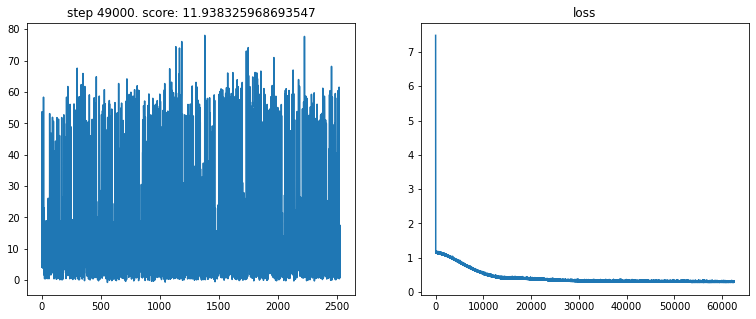

In [ ]:
# resume the training process
agent.resume_training(path='./training_test/checkpoints/rainbow_14000_16.65.pth', plot=True)